## Overview: Mistral-7B Classification Extraction with Prompt Based Few-shot Learning

In this tutorial we will use the state-of-art Large Language Model (LLM) Mistral-7B to classify climate-related literatures.

Nowadays pretrained large language models (LLMs) are widely used in many sub-fields of natural language processing (NLP) and generally known as excellent few-shot learners with task-specific exemplars. Notably, chain of thought (CoT) prompting, a recent technique for eliciting complex multi-step reasoning through step-bystep answer examples, achieved the state-of-the-art performances in arithmetics and symbolic reasoning (Kojima et al., 2022).

In our previous exploration, we concentrated on the traditional methods of training supervised natural language processing (NLP) models for the task of text classification. However, the field has seen significant advancements with the introduction of large language models (LLMs). These developments have brought a new paradigm to the forefront: prompting. This technique leverages natural language prompts to interact with a pre-trained machine learning model, using text for both input and output.

The structure of this tutorial is as follows:

1. Dataset Preparation: We will start by loading our dataset and preparing it for the process of prompt-based classification.

2. In-Context Learning (Zero/Few-shot Learning): We will enhance our prompting strategy by incorporating in-context knowledge into the prompt. This approach enriches the prompt with a context that aids the model in understanding and performing the classification task. Additionally, we will explore ways to extend the context of the input text to provide the model with richer information for decision-making.

Throughout this tutorial, we'll dive into how these techniques can be effectively utilized for NLP tasks, paving the way for interaction with LLMs beyond the confines of traditional supervised learning frameworks, as well as BERT-based deep learning models.

### Install and import packages

In [162]:
#feel free to use the torch version that you prefer
import os

!pip3 install torch==2.1.0+cu118 torchvision==0.16.0+cu118 torchaudio==2.1.0 -f https://download.pytorch.org/whl/torch_stable.html

Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://download.pytorch.org/whl/torch_stable.html
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [163]:
!pip3 install transformers
!pip3 install accelerate
!pip3 install -i https://test.pypi.org/simple/ bitsandbytes

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://test.pypi.org/simple/


#### First of all, we need to connect to the Data Science Lab GPU server!

Please follow the instructions in the below link:
https://hertie-data-science.gitbook.io/hertie-school-gpu/

In [164]:
# Info on the GPU that I am using
!nvidia-smi
# Info on available ram
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('\n\nYour runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Thu Dec 14 10:56:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  Off  | 00000000:01:00.0 Off |                    0 |
| N/A   25C    P0    32W / 250W |  14518MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-PCI...  Off  | 00000000:41:00.0 Off |                    0 |
| N/A   

### Load the Mistral-7B model from Huggling Face

In [165]:
# Check working directory
!pwd

/workspace


In [166]:
# Create new cache folder for huggingface models
!mkdir cache
!ls

mkdir: cannot create directory ‘cache’: File exists
GPU_server_test_notebook.ipynb	cache  workspace


In [167]:
# Change the cache folder for our transfer
import os
os.environ['TRANSFORMERS_CACHE'] = '/workspace/workspace/cache'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    GenerationConfig,
    TextStreamer,
    pipeline,
)

device = "cuda" # the device to load the model onto

MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.1"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, device_map="auto", torch_dtype=torch.float16, cache_dir='/workspace/workspace/cache'
)

torch.cuda.empty_cache() 

generation_config = GenerationConfig.from_pretrained(MODEL_NAME)
generation_config.max_new_tokens = 1024
generation_config.temperature = 0.0001
generation_config.do_sample = True

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [168]:
print(torch.__version__)
print(torch.cuda.is_available())

2.1.0+cu118
True


In [169]:
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

In [170]:
# Build the pipeline for our Mistral-7B model
llm = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    return_full_text=True,
    generation_config=generation_config,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.eos_token_id,
    streamer=streamer,
)

### Import dataset and explore it

In [171]:
import pandas as pd
from huggingface_hub import hf_hub_download
import matplotlib.pyplot as plt
import numpy as np
import re
import time

In [172]:
# Specify a cache directory that the process has write permissions for
custom_cache_dir = "/tmp/hf_cache"

# Here we will download the openalex dataset from the huggingface hub
filepath = hf_hub_download(repo_id="dspoka/ccai-nlp-tutorial-1", filename="openalex_data.csv", repo_type="dataset", cache_dir=custom_cache_dir)
with open(filepath, encoding='utf-8') as f:
    unlabeled_data = pd.read_csv(f)


print(f'The dataset has {unlabeled_data.shape[0]} rows and {unlabeled_data.shape[1]} columns')
print(f'The columns are: {unlabeled_data.columns.values}')
unlabeled_data.head()

The dataset has 24906 rows and 6 columns
The columns are: ['id' 'doi' 'title' 'publication_year' 'abstract' 'authors']


,id,doi,title,publication_year,abstract,authors
0,https://openalex.org/W2076977109,https://doi.org/10.1038/nature03906,Increasing destructiveness of tropical cyclone...,2005,NaN,Kerry Emanuel
1,https://openalex.org/W2171979944,https://doi.org/10.1007/s00425-003-1105-5,"Plant responses to drought, salinity and extre...",2003,NaN,"Wang-Xia Wang, Basia Vinocur, Arie Altman"
2,https://openalex.org/W2122582889,https://doi.org/10.1073/pnas.0505734102,Regional vegetation die-off in response to glo...,2005,Future drought is projected to occur under war...,"David D. Breshears, Neil S. Cobb, Paul Rich, K..."
3,https://openalex.org/W2170327428,https://doi.org/10.1073/pnas.1422385112,Anthropogenic warming has increased drought ri...,2015,Significance California ranks first in the Uni...,"Noah S. Diffenbaugh, Daniel L. Swain, Danielle..."
4,https://openalex.org/W2154180993,https://doi.org/10.1038/nature04188,Impact of regional climate change on human health,2005,NaN,"Jonathan A. Patz, Diarmid Campbell-Lendrum, Tr..."


In [173]:
filepath = hf_hub_download(repo_id="dspoka/ccai-nlp-tutorial-1", filename="labelled_data.csv", repo_type="dataset", cache_dir=custom_cache_dir)
with open(filepath, encoding='utf-8') as f:
    df = pd.read_csv(f)

# We create a lower case version of the title without spaces and punctuation, to allow for merging
df["title_lcase"] = df["title"].apply(lambda x: re.sub("\W", "", x).lower() if isinstance(x, str) else x)

# We also want to get rid of documents without abstracts, as we can't use these for learning
df = df.dropna(subset=["abstract"])
print(df.shape)

df.drop(['title_lcase'], axis=1, inplace=True)
df.rename(columns={'12 - Coastal and marine Ecosystems': 'Coastal and marine ecosystems',
                             '12 - Human and managed': 'Human and managed',
                             '12 - Mountains, snow and ice': 'Mountains, snow and ice',
                             '12 - Rivers, lakes, and soil moisture': 'Rivers, lakes, and soil moisture',
                             '12 - Terrestrial ES': 'Terrestrial ecosystems'}, inplace=True)
df.head()

(2500, 11)


,id,abstract,title,seen,INCLUDE,Coastal and marine ecosystems,Human and managed,"Mountains, snow and ice","Rivers, lakes, and soil moisture",Terrestrial ecosystems
0,1448689,"The city of Bismarck, North Dakota has one of ...",Key Factors Influencing the Incidence of West ...,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,3281128,Changing precipitation regimes can profoundly ...,Asymmetric responses of plant community struct...,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2,900708,Climate influences forest structure through ef...,Climate effects on fire regimes and tree recru...,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3,3234419,"Climate change is likely to bring more, hotter...",Climate change adaptation and mitigation ? a h...,1.0,1.0,0.0,1.0,0.0,0.0,0.0
4,2090028,Aim The long-term stability of coastal ecosyst...,Caribbean mangroves adjust to rising sea level...,1.0,1.0,1.0,0.0,0.0,0.0,0.0


In [174]:
from pickle import TRUE

# Count the number of each category
categories = ['Coastal and marine ecosystems', 'Human and managed', 'Mountains, snow and ice',
              'Rivers, lakes, and soil moisture', 'Terrestrial ecosystems']

# Calculate the number of labels per row
df['label_count'] = df[categories].sum(axis=1)

# Filtering out rows with multiple labels or zero labels
df_clean = df[(df['label_count'] == 1)]

# Dropping the 'label_count' column as it's no longer needed
df_clean = df_clean.drop(columns=['seen', 'INCLUDE'])

df_clean = df_clean.reset_index(drop=True)

df_clean.head()

,id,abstract,title,Coastal and marine ecosystems,Human and managed,"Mountains, snow and ice","Rivers, lakes, and soil moisture",Terrestrial ecosystems,label_count
0,1448689,"The city of Bismarck, North Dakota has one of ...",Key Factors Influencing the Incidence of West ...,0.0,1.0,0.0,0.0,0.0,1.0
1,3281128,Changing precipitation regimes can profoundly ...,Asymmetric responses of plant community struct...,0.0,0.0,0.0,0.0,1.0,1.0
2,900708,Climate influences forest structure through ef...,Climate effects on fire regimes and tree recru...,0.0,0.0,0.0,0.0,1.0,1.0
3,3234419,"Climate change is likely to bring more, hotter...",Climate change adaptation and mitigation ? a h...,0.0,1.0,0.0,0.0,0.0,1.0
4,2090028,Aim The long-term stability of coastal ecosyst...,Caribbean mangroves adjust to rising sea level...,1.0,0.0,0.0,0.0,0.0,1.0


In [175]:
# Define a function to get the label from the row
def get_label(row):
    categories = ['Coastal and marine ecosystems', 'Human and managed', 'Mountains, snow and ice', 'Rivers, lakes, and soil moisture', 'Terrestrial ecosystems']
    for category in categories:
        if row[category] == 1.0:
            return category
    return "Unknown"

# Add a new column to the DataFrame with the label names
df_clean['True Category'] = df_clean.apply(get_label, axis=1)

In [176]:
df_clean.head()

,id,abstract,title,Coastal and marine ecosystems,Human and managed,"Mountains, snow and ice","Rivers, lakes, and soil moisture",Terrestrial ecosystems,label_count,True Category
0,1448689,"The city of Bismarck, North Dakota has one of ...",Key Factors Influencing the Incidence of West ...,0.0,1.0,0.0,0.0,0.0,1.0,Human and managed
1,3281128,Changing precipitation regimes can profoundly ...,Asymmetric responses of plant community struct...,0.0,0.0,0.0,0.0,1.0,1.0,Terrestrial ecosystems
2,900708,Climate influences forest structure through ef...,Climate effects on fire regimes and tree recru...,0.0,0.0,0.0,0.0,1.0,1.0,Terrestrial ecosystems
3,3234419,"Climate change is likely to bring more, hotter...",Climate change adaptation and mitigation ? a h...,0.0,1.0,0.0,0.0,0.0,1.0,Human and managed
4,2090028,Aim The long-term stability of coastal ecosyst...,Caribbean mangroves adjust to rising sea level...,1.0,0.0,0.0,0.0,0.0,1.0,Coastal and marine ecosystems


### Using prompting to classify the academic paper based on abstract
In this section, we'll establish the framework for the classification task at hand. Moving away from the approach of the previous tutorial, where we fine-tuned classifiers using supervised data, we'll now shift our strategy towards engaging a Large Language Model (LLM) to accomplish the task through zero-shot and few-shot techniques.

#### Introducing Prompting Techniques
- Large Language Models (LLMs) are generally pre-trained on extensive corpora of text data using a self-supervised learning objective, which involves predicting subsequent words in a sequence.
- The essence of prompting lies in reformulating a given task, such as classification, into a form that aligns with the model's pre-training objective of word prediction.
- Consider a sentiment analysis example with the sentence "I loved this movie, it was a blast!" where the correct sentiment is "positive."
- We can apply a prompting template like "{Movie Review}. This movie is {sentiment}" to restructure the task:
   - Model input: "I loved this movie, it was a blast! This movie is"
   - We then assess the likelihood of the model predicting "positive" or "negative" as the next word.
- The sentiment with the higher predicted probability is selected as the label.
- This exemplifies a basic form of prompting, where we convert a sentiment classification task into a next-word prediction problem, enabling us to utilize the pre-trained model directly without the need for extra training parameters.

#### Mistral-7B and Prompting
- The straightforward prompting example previously described offers a glimpse into the potential of prompt-based interaction, yet contemporary LLMs exhibit far greater adaptability with regard to the prompts they can process effectively.
- These models have undergone additional training with instruction-following datasets, empowering them to execute tasks that extend beyond mere next-word prediction, where the responses may not be directly inferable as the subsequent word.
- In the initial secrion of our exploration, we aim to craft an instructive prompt that succinctly conveys the essence of our task—classifying abstracts—to the model.

### Zero-shot learning (with different prompting strategy) of text classification

The University of Tokyo, in collaboration with Google Research, published a paper titled "Large Language Models as Zero-Shot Reasoners" (Kojima et al., 2022) in 2022, in which they demonstrated that LLMs are excellent zero-shot reasoners by adding "Let's think step-by-step" before each answer. Experimental results show that their Zero-shot-CoT outperforms the zero-shot LLM significantly in a variety of benchmark reasoning tasks, including arithmetic, using the same single-prompt template.

After this, Google DeepMind released another paper titled "LARGE LANGUAGE MODELS AS OPTIMIZERS" (Yang, C et al., 2023). In their work, they proposed Optimization by PROmpting (OPRO), a simple and effective approach to leverage large language models (LLMs) as optimizers, where the optimization task is described in natural language. In each optimization step, the LLM generates new solutions from the prompt that contains previously generated solutions with their values, then the new solutions are evaluated and added to the prompt for the next optimization step. They added this sentence "Take a deep breath and work on this problem step-by-step" and achieved better results.

#### Strategy 1
In strategy 1, we told Mistral-7B to consider itself as a highly knowledgeable assistant in environmental science and climate policy and explained what each category meant, then asked the model to perform the classification task.

In [177]:
test = df_clean
test = test.copy()  # Make a copy if df_clean is a slice from another DataFrame

In [178]:
def format_prompts(prompt, system_prompt=""):
    if system_prompt.strip():
        return f"[INST] {system_prompt} {prompt} [/INST]"
    return f"[INST] {prompt} [/INST]"

In [179]:
# Define the system prompt (instruction for the LLM)
# It is always very tricky
# Strategy 1

SYSTEM_PROMPT = """As a highly knowledgeable assistant in environmental science and climate policy, your task is to classify the following climate change academic papers into the most relevant category based on their abstracts. The five categories are: 
                1. Coastal and marine ecosystems - Papers that focus on oceanic and coastal habitats, marine biodiversity, or ocean-related environmental issues;
                2. Human and managed - Papers that deal with human-environment interactions, environmental policy, or managed ecosystems like agriculture or urban areas;
                3. Mountains, snow and ice - Papers that concentrate on mountainous regions, glacial studies, or snow and ice-related environmental topics; 
                4. Rivers, lakes, and soil moisture - Papers that explore freshwater ecosystems, including rivers, lakes, and wetlands, or studies on soil moisture and its environmental impact;
                5. Terrestrial ecosystems - Papers that discuss land-based ecosystems, their services, terrestrial biodiversity, or conservation efforts on land.
                Please categorize the abstracts you receive and provide what you believe to be the correct category after carefully analyzing the abstracts.
                In the output, you just need to provide a concise answer for each abstract based on your analysis. Category response is needed, don't leave it uncategorized. There is no need to explain why.""".strip()

In [180]:
# Function to calculate accuracy
def calculate_accuracy(predictions, actuals):
    correct = sum(p == a for p, a in zip(predictions, actuals))
    return correct / len(predictions)

# Function to extract the category from the LLM output
def extract_category(text):
    # Using regular expressions to find the category
    match = re.search(r'Category: ([\w\s,]+)\.', text)
    if match:
        # Extracting the category name from the match
        category_name = match.group(1).strip()
        # Mapping the name to the correct category
        if category_name in categories:
            return category_name
    print("Uncategorized or unclear category in output")
    return "Uncategorized"


# Function to format the prompts
def format_batch_prompts(abstracts, system_prompt):
    return [format_prompts(abstract, system_prompt) for abstract in abstracts]

# Define the batch size
batch_size = 10

# Initialize a list to hold all the predictions and accuracies
predictions = []
accuracies = []

# Record start time
start_time = time.time()

# Process the DataFrame in batches
for i in range(0, len(test), batch_size):
    batch_abstracts = test['abstract'][i:i+batch_size].tolist()
    batch_labels = test['True Category'][i:i+batch_size].tolist()
    batch_prompts = format_batch_prompts(batch_abstracts, SYSTEM_PROMPT)
    batch_results = llm(batch_prompts)
    
    batch_predictions = []
    for result in batch_results:
        if isinstance(result, list) and len(result) == 1 and 'generated_text' in result[0]:
            predicted_category = extract_category(result[0]['generated_text'])
            batch_predictions.append(predicted_category)
        else:
            batch_predictions.append("Uncategorized")
            print("Unexpected result format from the language model.")

    predictions.extend(batch_predictions)
    print(f"Processed {i + len(batch_abstracts)} abstracts out of {len(test)}")

    # Calculate and store accuracy for the batch
    batch_accuracy = calculate_accuracy(batch_predictions, batch_labels)
    accuracies.append(batch_accuracy)   
    
# Record end time
end_time = time.time()    
    
# Check and assign predictions
if len(predictions) == len(test):
    test['Predicted Category'] = predictions
else:
    raise ValueError("Mismatch in the number of predictions and DataFrame rows.")

Category: Human and managed.
Category: Terrestrial ecosystems.
Category: Terrestrial ecosystems.
Category: Human and managed.
Category: Coastal and marine ecosystems.
Category: Human and managed.
Category: Human and managed.
Category: Mountains, snow and ice.
Category: Human and managed.
Category: Human and managed.
Processed 10 abstracts out of 1266
Category: Coastal and marine ecosystems.
Category: Coastal and marine ecosystems.
Category: Human and managed.
Category: Coastal and marine ecosystems.
Category: Human and managed.
Category: Human and managed.
Category: Mountains, snow and ice.
Category: Human and managed.
Category: Coastal and marine ecosystems.
Category: Human and managed.
Processed 20 abstracts out of 1266
Category: Coastal and marine ecosystems.
Category: Terrestrial ecosystems.
Category: Human and managed.
Category: Human and managed.
Category: Human and managed.
Category: Terrestrial ecosystems.
Category: Mountains, snow and ice.
Category: Coastal and marine ecosyste

/.local/lib/python3.8/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Category: Human and managed.
Category: Mountains, snow and ice.
Category: Terrestrial ecosystems.
Category: Human and managed.
Category: Terrestrial ecosystems.
Category: Human and managed.
Category: Coastal and marine ecosystems.
Category: Terrestrial ecosystems.
Category: Human and managed.
Category: Mountains, snow and ice.
Processed 110 abstracts out of 1266
Category: Human and managed.
Category: Terrestrial ecosystems.
Category: Mountains, snow and ice.
Category: Human and managed.
Category: Terrestrial ecosystems.
Category: Human and managed.
Category: Terrestrial ecosystems.
Category: Coastal and marine ecosystems.
Category: Human and managed.
Category: Human and managed.
Processed 120 abstracts out of 1266
Category: Human and managed.
Category: Human and managed.
Category: Terrestrial ecosystems.
Category: Rivers, lakes, and soil moisture.
Category: Human and managed.
Category: Coastal and marine ecosystems.
Category: Human and managed.
Category: Human and managed.
Category: Te

In [181]:
# Define the mapping of columns to category names
category_mapping = {
    'Coastal and marine ecosystems': 'Coastal and marine ecosystems',
    'Human and managed': 'Human and managed',
    'Mountains, snow and ice': 'Mountains, snow and ice',
    'Rivers, lakes, and soil moisture': 'Rivers, lakes, and soil moisture',
    'Terrestrial ecosystems': 'Terrestrial ecosystems'
}

correct_predictions = 0
total_predictions = len(test)

for _, row in test.iterrows():
    # Determine the true category based on the columns
    true_category = next((category for category, name in category_mapping.items() if row[category] == 1.0), None)
    
    # Compare with the predicted category
    if true_category and row['Predicted Category'] == category_mapping[true_category]:
        correct_predictions += 1

accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate total processing time
total_time = end_time - start_time
print(f"Total processing time: {total_time} seconds")

Accuracy: 61.06%
Total processing time: 5148.650587081909 seconds


In [182]:
# Print accuracies for each batch
for i, acc in enumerate(accuracies, 1):
    print(f"Batch {i} Accuracy: {acc}")

# Print overall accuracy
overall_accuracy = sum(accuracies) / len(accuracies)
print(f"Overall Accuracy: {overall_accuracy}")

Batch 1 Accuracy: 0.9
Batch 2 Accuracy: 0.4
Batch 3 Accuracy: 0.5
Batch 4 Accuracy: 0.5
Batch 5 Accuracy: 0.5
Batch 6 Accuracy: 0.9
Batch 7 Accuracy: 0.8
Batch 8 Accuracy: 0.8
Batch 9 Accuracy: 0.7
Batch 10 Accuracy: 0.8
Batch 11 Accuracy: 0.7
Batch 12 Accuracy: 0.6
Batch 13 Accuracy: 0.5
Batch 14 Accuracy: 0.7
Batch 15 Accuracy: 1.0
Batch 16 Accuracy: 0.6
Batch 17 Accuracy: 0.5
Batch 18 Accuracy: 0.5
Batch 19 Accuracy: 0.8
Batch 20 Accuracy: 0.3
Batch 21 Accuracy: 0.6
Batch 22 Accuracy: 0.4
Batch 23 Accuracy: 0.6
Batch 24 Accuracy: 0.8
Batch 25 Accuracy: 0.7
Batch 26 Accuracy: 0.7
Batch 27 Accuracy: 0.6
Batch 28 Accuracy: 0.8
Batch 29 Accuracy: 0.3
Batch 30 Accuracy: 0.5
Batch 31 Accuracy: 0.5
Batch 32 Accuracy: 0.6
Batch 33 Accuracy: 0.5
Batch 34 Accuracy: 0.5
Batch 35 Accuracy: 0.8
Batch 36 Accuracy: 0.4
Batch 37 Accuracy: 0.2
Batch 38 Accuracy: 0.5
Batch 39 Accuracy: 0.8
Batch 40 Accuracy: 0.8
Batch 41 Accuracy: 0.7
Batch 42 Accuracy: 0.8
Batch 43 Accuracy: 0.6
Batch 44 Accuracy: 0

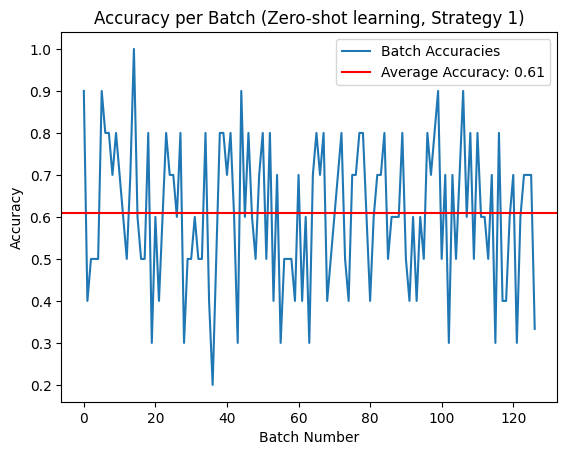

In [183]:
# Calculate the average accuracy
average_accuracy = sum(accuracies) / len(accuracies)

# Plotting the accuracies
plt.plot(accuracies, label='Batch Accuracies')
plt.axhline(y=average_accuracy, color='r', linestyle='-', label=f'Average Accuracy: {average_accuracy:.2f}')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy')
plt.title('Accuracy per Batch (Zero-shot learning, Strategy 1)')
plt.legend()
plt.show()

To be honest, the initial performance of Mistral-7B was much better than we expected, but it was also not very stable according to the graph.

#### Strategy 2
In strategy 2, as we explained earlier, we just added one more sentence as a booster shot: "Take a deep breath and work on this problem step-by-step", the rest remains the same.

In [184]:
test_2 = df_clean
test_2 = test_2.copy() 

In [185]:
# Strategy 2
# Add this sententce "Take a deep breath and work on this problem step-by-step." to the prompt after reading the academic paper (LARGE LANGUAGE MODELS AS OPTIMIZERS)

SYSTEM_PROMPT_2 = """As a highly knowledgeable assistant in environmental science and climate policy, your task is to classify the following climate change academic papers into the most relevant category based on their abstracts. The five categories are: 
                1. Coastal and marine ecosystems - Papers that focus on oceanic and coastal habitats, marine biodiversity, or ocean-related environmental issues;
                2. Human and managed - Papers that deal with human-environment interactions, environmental policy, or managed ecosystems like agriculture or urban areas;
                3. Mountains, snow and ice - Papers that concentrate on mountainous regions, glacial studies, or snow and ice-related environmental topics; 
                4. Rivers, lakes, and soil moisture - Papers that explore freshwater ecosystems, including rivers, lakes, and wetlands, or studies on soil moisture and its environmental impact;
                5. Terrestrial ecosystems - Papers that discuss land-based ecosystems, their services, terrestrial biodiversity, or conservation efforts on land.
                Please categorize the abstracts you receive and provide what you believe to be the correct category after carefully analyzing the abstracts.
                In the output, you just need to provide a concise answer for each abstract based on your analysis. Category response is needed, don't leave it uncategorized. There is no need to explain why.
                Take a deep breath and work on this problem step-by-step.""".strip()

In [186]:
# Initialize a list to hold all the predictions and accuracies for the second dataset
predictions_2 = []
accuracies_2 = []

# Record start time
start_time_2 = time.time()

# Process the DataFrame in batches
for i in range(0, len(test_2), batch_size):
    batch_abstracts_2 = test_2['abstract'][i:i+batch_size].tolist()
    batch_labels_2 = test_2['True Category'][i:i+batch_size].tolist()
    batch_prompts_2 = format_batch_prompts(batch_abstracts_2, SYSTEM_PROMPT_2)
    batch_results_2 = llm(batch_prompts_2)
    
    batch_predictions_2 = []
    for result in batch_results_2:
        if isinstance(result, list) and len(result) == 1 and 'generated_text' in result[0]:
            predicted_category_2 = extract_category(result[0]['generated_text'])
            batch_predictions_2.append(predicted_category_2)
        else:
            batch_predictions_2.append("Uncategorized")
            print("Unexpected result format from the language model.")

    predictions_2.extend(batch_predictions_2)
    print(f"Processed {i + len(batch_abstracts_2)} abstracts out of {len(test_2)}")

    # Calculate and store accuracy for each batch
    batch_accuracy_2 = calculate_accuracy(batch_predictions_2, batch_labels_2)
    accuracies_2.append(batch_accuracy_2)

# Record end time
end_time_2 = time.time()

# Check and assign predictions
if len(predictions_2) == len(test_2):
    test_2['Predicted Category'] = predictions_2
else:
    raise ValueError("Mismatch in the number of predictions and DataFrame rows.")

/.local/lib/python3.8/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Category: Human and managed.
Category: Terrestrial ecosystems.
Category: Terrestrial ecosystems.
Category: Human and managed.
Category: Coastal and marine ecosystems.
Category: Human and managed.
Category: Human and managed.
Category: Mountains, snow and ice.
Category: Human and managed.
Category: Human and managed.
Processed 10 abstracts out of 1266
Category: Terrestrial ecosystems.
Category: Coastal and marine ecosystems.
Category: Human and managed.
Category: Coastal and marine ecosystems.
Category: Human and managed.
Category: Human and managed.
Category: Mountains, snow and ice.
Category: Human and managed.
Category: Coastal and marine ecosystems.
Category: Human and managed.
Processed 20 abstracts out of 1266
Category: Coastal and marine ecosystems.
Category: Terrestrial ecosystems.
Category: Human and managed.
Category: Human and managed.
Category: Human and managed.
Category: Terrestrial ecosystems.
Category: Mountains, snow and ice.
Category: Coastal and marine ecosystems.
Cat

In [187]:
# Define the mapping of columns to category names
category_mapping = {
    'Coastal and marine ecosystems': 'Coastal and marine ecosystems',
    'Human and managed': 'Human and managed',
    'Mountains, snow and ice': 'Mountains, snow and ice',
    'Rivers, lakes, and soil moisture': 'Rivers, lakes, and soil moisture',
    'Terrestrial ecosystems': 'Terrestrial ecosystems'
}

correct_predictions_2 = 0
total_predictions_2 = len(test_2)

for _, row in test_2.iterrows():
    # Determine the true category based on the columns
    true_category = next((category for category, name in category_mapping.items() if row[category] == 1.0), None)
    
    # Compare with the predicted category
    if true_category and row['Predicted Category'] == category_mapping[true_category]:
        correct_predictions_2 += 1

accuracy_2 = correct_predictions_2 / total_predictions_2
print(f"Accuracy: {accuracy_2 * 100:.2f}%")

# Calculate and print the total processing time
total_time_2 = end_time_2 - start_time_2
print(f"Total processing time: {total_time_2} seconds")

Accuracy: 63.03%
Total processing time: 5016.460675954819 seconds


In [188]:
# Print accuracies for each batch for the second dataset
for i, acc in enumerate(accuracies_2, 1):
    print(f"Batch {i} Accuracy: {acc}")

# Print overall accuracy for the second dataset
overall_accuracy_2 = sum(accuracies_2) / len(accuracies_2)
print(f"Overall Accuracy: {overall_accuracy_2}")

Batch 1 Accuracy: 0.9
Batch 2 Accuracy: 0.5
Batch 3 Accuracy: 0.5
Batch 4 Accuracy: 0.4
Batch 5 Accuracy: 0.5
Batch 6 Accuracy: 0.9
Batch 7 Accuracy: 0.8
Batch 8 Accuracy: 0.9
Batch 9 Accuracy: 0.7
Batch 10 Accuracy: 0.7
Batch 11 Accuracy: 0.7
Batch 12 Accuracy: 0.6
Batch 13 Accuracy: 0.5
Batch 14 Accuracy: 0.6
Batch 15 Accuracy: 1.0
Batch 16 Accuracy: 0.6
Batch 17 Accuracy: 0.6
Batch 18 Accuracy: 0.7
Batch 19 Accuracy: 0.8
Batch 20 Accuracy: 0.3
Batch 21 Accuracy: 0.7
Batch 22 Accuracy: 0.4
Batch 23 Accuracy: 0.9
Batch 24 Accuracy: 0.7
Batch 25 Accuracy: 0.7
Batch 26 Accuracy: 0.6
Batch 27 Accuracy: 0.6
Batch 28 Accuracy: 0.8
Batch 29 Accuracy: 0.3
Batch 30 Accuracy: 0.5
Batch 31 Accuracy: 0.5
Batch 32 Accuracy: 0.6
Batch 33 Accuracy: 0.5
Batch 34 Accuracy: 0.7
Batch 35 Accuracy: 0.8
Batch 36 Accuracy: 0.5
Batch 37 Accuracy: 0.5
Batch 38 Accuracy: 0.5
Batch 39 Accuracy: 0.9
Batch 40 Accuracy: 0.8
Batch 41 Accuracy: 0.6
Batch 42 Accuracy: 0.8
Batch 43 Accuracy: 0.6
Batch 44 Accuracy: 0

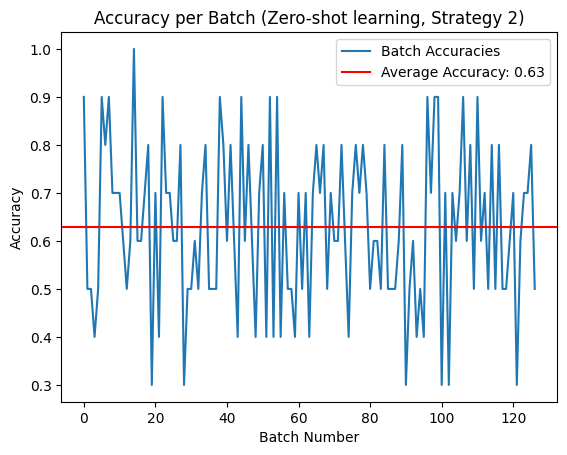

In [189]:
# Calculate the average accuracy
average_accuracy_2 = sum(accuracies_2) / len(accuracies_2)

# Plotting the accuracies
plt.plot(accuracies_2, label='Batch Accuracies')
plt.axhline(y=average_accuracy_2, color='r', linestyle='-', label=f'Average Accuracy: {average_accuracy_2:.2f}')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy')
plt.title('Accuracy per Batch (Zero-shot learning, Strategy 2)')
plt.legend()
plt.show()

After running again, we see that the accuracy has reached 63%, but it is still not very stable. The performance of the booster shot was not as good as described in the paper, but we did not find the reason behind it, which needs to be explored in the future.

### Few-shot (two) learning of text classification
We now propose a concise prompt with the instruction, 2 in-context (long) learning examples from the dataset for each category.

In [190]:
test_few = df_clean
test_few = test_few.copy()

In [191]:
# Two-shot learning prompt strategy

SYSTEM_PROMPT_few = """As a highly knowledgeable assistant in environmental science and climate policy, your task is to classify the following climate change academic papers into the most relevant category based on their abstracts.
                The five categories are:
                1.'Coastal and marine ecosystems',
                2.'Human and managed',
                3.'Mountains, snow and ice',
                4.'Rivers, lakes, and soil moisture',
                5.'Terrestrial ecosystems'.                
                
                There are now two correct abstract examples for each category so that you can better understand and learn the patterns of abstracts in each category.
                
                For Coastal and marine ecosystems:
                Example 1: This study examines the impact of global climate change on marine and estuarine fish, focusing on the effects on fish growth, digestion, and overall performance in both marine and freshwater ecosystems. It highlights the need for understanding the cause and effect of climate-induced temperature and salinity changes on fish physiology. The research suggests that global warming could shift the distribution limits of fish species, potentially leading to changes in their growth performance or even extinction, particularly in tropical regions where research is less extensive.
                Example 2: The research analyzes how oceanic phytoplankton are affected by climate-driven changes, especially under the influence of El Niño variations in the Earth-climate system. Using observational and reanalysis datasets, it distinguishes the physical forces driving changes in phytoplankton due to Eastern Pacific and Central Pacific types of El Niño. The findings indicate significant impacts on phytoplankton, mainly in the tropics and subtropics, and highlight the importance of understanding these mechanisms for predicting future changes in marine ecosystems and developing climate adaptation strategies.

                For Human and managed:
                Example 1: This study examines the multifaceted impact of climate change on human migration. It identifies various thresholds in climate adaptation and migration, shaped by environmental events and human perceptions. These thresholds range from the necessity of adaptation to the shift towards non-linear migration patterns. The research emphasizes the importance of understanding these dynamics for future policy-making, especially in the context of escalating climate change.
                Example 2: This paper focuses on the changing dynamics in the Arctic due to climate change, particularly affecting marine mammal-human interactions. It highlights the challenges faced by communities dependent on marine mammals for livelihood, amid changing environmental conditions like diminishing sea ice and increased industrial activities. The study stresses the need for comprehensive strategies to mitigate the negative impacts on both marine mammals and dependent communities.
                
                For Mountains, snow and ice:
                Example 1: This study explores the significant role of snow in the Arctic climate system, focusing on how snow depth variations, particularly in spring, impact the energy budget of Arctic sea ice. It highlights the influence of rain-on-snow events on snow ablation and the consequent sea ice melt. Observations at Utqiagvik, Alaska, indicate that even minor rainfall can trigger significant changes in snowpack conditions, leading to faster melting. The study underscores the increasing trend of early melt season rainfall and its implications for sea ice dynamics.
                Example 2: The research contrasts climatic changes in the Arctic and Antarctic, emphasizing their divergent responses to global warming. The Arctic has experienced a substantial decrease in sea ice, accelerated by positive ice-albedo feedback, while Antarctic sea ice has shown growth, particularly in autumn. The study notes the varied warming patterns across these polar regions, influenced by geographical factors like topography and land/sea distribution, as well as the effects of the Antarctic ozone hole on atmospheric and oceanic circulations.
                
                For Rivers, lakes, and soil moisture
                Example 1: This study involves the development of a daily watershed model for the Sacramento River Basin in Northern California, aiming to simulate streamflow and sediment transport. The model, addressing data scarcity, integrates meteorological variables, evapotranspiration, and hydraulic geometry. It reveals a slight but significant decline in sediment loads, correlating with climate-induced changes such as seasonal shifts and reduced snowpack. The model’s sensitivity to various climate scenarios, including temperature changes, indicates an increase in sediment discharge with greater storm frequency and a decrease with rising air temperatures. This model serves as a tool for predicting future hydrologic and sediment trends in the Sacramento River Basin, contributing to the ecological assessment of the Bay-Delta region.
                Example 2: The research analyzes global drought occurrence from 1950-2000 using the VIC land surface model, focusing on soil moisture data. A monthly drought index, based on soil moisture percentiles, assesses droughts in terms of duration, intensity, and severity. The study finds that short-term droughts are common in tropical and mid-latitude regions, while medium and long-term droughts are frequent in higher latitudes and sub-Saharan Africa, respectively. Notable drought events, such as the 1988 US and 1982/83 Australian droughts, are identified, with the analysis highlighting a divergence from the Palmer Drought Severity Index in cooler regions and seasons, particularly in recent years. The research underscores the importance of understanding soil moisture dynamics in assessing and preparing for drought impacts under varying climatic conditions.
                
                For Terrestrial ecosystems:
                Example 1: This study assesses plant phenology as a bioindicator of climate change in the Mediterranean. Analyzing over 200,000 records of 29 perennial plant species from 1943 to 2003, the study investigates temperature, precipitation, and the North Atlantic Oscillation's impact on six phenological events. Findings indicate that warmer and drier springs advance key phenological stages like flowering, leaf unfolding, and fruiting, while also extending the growing season. The study highlights the varying sensitivity of different plant events and species to climate, showing that spring events are more susceptible to climate change than autumn ones. Insect-pollinated species show a stronger climate response than wind-pollinated species. Overall, the research underscores significant shifts in plant phenology in the Mediterranean due to climate change.
                Example 2: Focusing on biotic interactions under climate change, this research explores how dominant plant species influence the population dynamics of co-occurring forbs in seminatural grasslands. Conducted across 12 sites in southern Norway, the study involves the experimental removal of graminoids and examines the climate-driven shifts in interactions between dominant and subordinate species. The findings reveal that as temperatures increase, competitive interactions intensify, adversely affecting subordinate species' survival. The study emphasizes the growing importance of competitive interactions under global warming, potentially leading to grasslands increasingly dominated by competitive species unless managed by disturbances like grazing or mowing. This research is pivotal in understanding the mechanisms behind plant responses to climate change at the population level.
                
                Please categorize the abstracts you receive and provide what you believe to be the correct category after carefully analyzing the abstracts.
                In the output, you just need to provide a concise answer for each abstract based on your analysis. Category response is needed, don't leave it uncategorized. There is no need to explain why.
                Take a deep breath and work on this problem step-by-step.""".strip()

#### Hallucinations of Mistral-7B
When we provide the raw abstracts of each paper and let it run, the output does not follow my prompt instructions and generates a lot of meaningless content. I think this is due to the original abstract of the paper being too long, and exceed the token limit of the Mistral-7B model, which caused the model have hallucination. Then I used ChatGPT to summarize those abstracts and maintain the original intent to the greatest extent possible.

Here are some potential reasons:
- Token Limitation: LLMs have a maximum token limit for each input sequence. Mistral-7B, like other models, can only process a certain number of tokens at a time. If an abstract exceeds this limit, the model won't be able to consider the entire text, which can lead to truncated inputs and consequently, incomplete understanding of the content.

- Complexity and Length of Abstracts: Academic abstracts are often dense and packed with specialized terminology and complex sentence structures. This complexity can make it difficult for the model to extract the main points and generate a succinct classification.

- Prompt Misalignment: If the prompt format doesn't align well with the pre-training of the LLM, it may not trigger the intended response. The model's training might not have covered similar tasks or the format of the prompt might be unfamiliar to the model.

- Model's Pre-training Bias: The model's responses are influenced by its pre-training data. If the pre-training data did not include similar tasks or enough examples of abstract classification, the model might not perform well on this task.

- Overwhelming Model with Information: Providing too much information in a single prompt can overwhelm the model, leading it to generate outputs that don't focus on the classification task at hand.

In [192]:
# Initialize a list to hold all the predictions and accuracies
predictions_few = []
accuracies_few = []

# Record start time
start_time_few = time.time()

# Process the DataFrame in batches
for i in range(0, len(test_few), batch_size):
    batch_abstracts_few = test_few['abstract'][i:i+batch_size].tolist()
    batch_labels_few = test_few['True Category'][i:i+batch_size].tolist()
    batch_prompts_few = format_batch_prompts(batch_abstracts_few, SYSTEM_PROMPT_few)
    batch_results_few = llm(batch_prompts_few)
    
    batch_predictions_few = []
    for result in batch_results_few:
        if isinstance(result, list) and len(result) == 1 and 'generated_text' in result[0]:
            predicted_category_few = extract_category(result[0]['generated_text'])
            batch_predictions_few.append(predicted_category_few)
        else:
            batch_predictions_few.append("Uncategorized")
            print("Unexpected result format from the language model.")

    predictions_few.extend(batch_predictions_few)
    print(f"Processed {i + len(batch_abstracts_few)} abstracts out of {len(test_few)}")

    # Calculate and store accuracy for each batch
    batch_accuracy_few = calculate_accuracy(batch_predictions_few, batch_labels_few)
    accuracies_few.append(batch_accuracy_few)

# Record end time for the third dataset
end_time_few = time.time()

# Check and assign predictions
if len(predictions_few) == len(test_few):
    test_few['Predicted Category'] = predictions_few
else:
    raise ValueError("Mismatch in the number of predictions and DataFrame rows.")

/.local/lib/python3.8/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Category: Human and managed.
Category: Terrestrial ecosystems.
Category: Terrestrial ecosystems.
Category: Human and managed.
Category: Coastal and marine ecosystems.
Category: Terrestrial ecosystems.
Category: Human and managed.
Category: Mountains, snow and ice.
Category: Human and managed.
Category: Terrestrial ecosystems.
Processed 10 abstracts out of 1266
Category response: Terrestrial ecosystems.
Category: Coastal and marine ecosystems.
Category: Human and managed.
Category: Coastal and marine ecosystems.
Category: Human and managed.
Category: Human and managed.
Category: Terrestrial ecosystems.
Category: Human and managed.
Category: Coastal and marine ecosystems.
Category: Rivers, lakes, and soil moisture.
Uncategorized or unclear category in output
Processed 20 abstracts out of 1266
Category: Coastal and marine ecosystems.
Category: Terrestrial ecosystems.
Category: Human and managed.
Category: Rivers, lakes, and soil moisture.
Category: Human and managed.
Category: Terrestrial

In [193]:
# Define the mapping of columns to category names
category_mapping = {
    'Coastal and marine ecosystems': 'Coastal and marine ecosystems',
    'Human and managed': 'Human and managed',
    'Mountains, snow and ice': 'Mountains, snow and ice',
    'Rivers, lakes, and soil moisture': 'Rivers, lakes, and soil moisture',
    'Terrestrial ecosystems': 'Terrestrial ecosystems'
}

correct_predictions_few = 0
total_predictions_few = len(test_few)

for _, row in test_few.iterrows():
    # Determine the true category based on the columns
    true_category = next((category for category, name in category_mapping.items() if row[category] == 1.0), None)
    
    # Compare with the predicted category
    if true_category and row['Predicted Category'] == category_mapping[true_category]:
        correct_predictions_few += 1

accuracy_few = correct_predictions_few / total_predictions_few
print(f"Accuracy: {accuracy_few * 100:.2f}%")

# Calculate and print the total processing time
total_time_few = end_time_few - start_time_few
print(f"Total processing time: {total_time_few} seconds")

Accuracy: 69.91%
Total processing time: 5833.85093164444 seconds


In [194]:
# Print accuracies for each batch
for i, acc in enumerate(accuracies_few, 1):
    print(f"Batch {i} Accuracy: {acc}")

# Print overall accuracy
overall_accuracy_few = sum(accuracies_few) / len(accuracies_few)
print(f"Overall Accuracy: {overall_accuracy_few}")

Batch 1 Accuracy: 0.9
Batch 2 Accuracy: 0.5
Batch 3 Accuracy: 0.8
Batch 4 Accuracy: 0.6
Batch 5 Accuracy: 0.8
Batch 6 Accuracy: 0.9
Batch 7 Accuracy: 0.7
Batch 8 Accuracy: 0.8
Batch 9 Accuracy: 0.9
Batch 10 Accuracy: 0.9
Batch 11 Accuracy: 0.8
Batch 12 Accuracy: 0.6
Batch 13 Accuracy: 0.6
Batch 14 Accuracy: 0.7
Batch 15 Accuracy: 1.0
Batch 16 Accuracy: 0.6
Batch 17 Accuracy: 0.6
Batch 18 Accuracy: 0.7
Batch 19 Accuracy: 0.6
Batch 20 Accuracy: 0.7
Batch 21 Accuracy: 0.8
Batch 22 Accuracy: 0.6
Batch 23 Accuracy: 0.9
Batch 24 Accuracy: 0.8
Batch 25 Accuracy: 0.6
Batch 26 Accuracy: 0.6
Batch 27 Accuracy: 0.8
Batch 28 Accuracy: 0.6
Batch 29 Accuracy: 0.7
Batch 30 Accuracy: 0.5
Batch 31 Accuracy: 0.5
Batch 32 Accuracy: 0.7
Batch 33 Accuracy: 0.6
Batch 34 Accuracy: 0.5
Batch 35 Accuracy: 0.9
Batch 36 Accuracy: 0.7
Batch 37 Accuracy: 0.6
Batch 38 Accuracy: 0.6
Batch 39 Accuracy: 0.7
Batch 40 Accuracy: 0.6
Batch 41 Accuracy: 0.8
Batch 42 Accuracy: 0.7
Batch 43 Accuracy: 0.5
Batch 44 Accuracy: 0

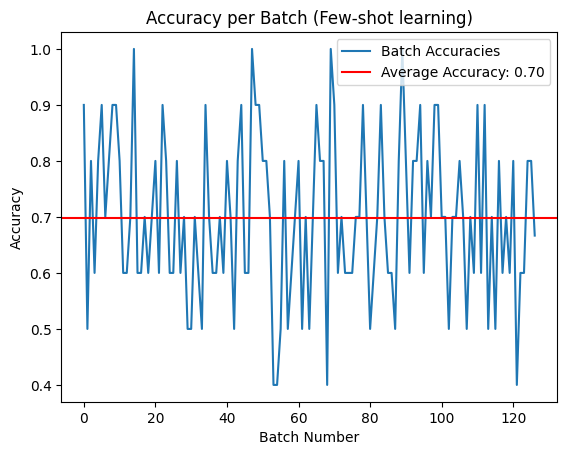

In [195]:
# Calculate the average accuracy
average_accuracy_few = sum(accuracies_few) / len(accuracies_few)

# Plotting the accuracies
plt.plot(accuracies_few, label='Batch Accuracies')
plt.axhline(y=average_accuracy_few, color='r', linestyle='-', label=f'Average Accuracy: {average_accuracy_few:.2f}')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy')
plt.title('Accuracy per Batch (Few-shot learning)')
plt.legend()
plt.show()

From the graph we can observe that after two-shot learning, the accuracy of Mistral-7B model becomes more stable throughout the process (there are far fewer extremes of prediction error.). The final accuracy also reached 70%, exceeding the previous zero-shot learning results, but failed to meet our expectations (80% - 90%). We think this is mainly a limitation of the model itself and the complexity of the classification task (especially when it comes to text).

### Bonus task: Text Summary and Analysis

#### Without detailed prompts and knowledge input

In [211]:
text = "[INST] Summarize and analyze this diplomatic statement: President Joseph R. Biden, Jr. today held a Summit with President Xi Jinping of the People’s Republic of China (PRC), in Woodside, California.  The two leaders held a candid and constructive discussion on a range of bilateral and global issues including areas of potential cooperation and exchanged views on areas of difference. President Biden emphasized that the United States and China are in competition, noting that the United States would continue to invest in the sources of American strength at home and align with allies and partners around the world.  He stressed that the United States would always stand up for its interests, its values, and its allies and partners.  He reiterated that the world expects the United States and China to manage competition responsibly to prevent it from veering into conflict, confrontation, or a new Cold War. The two leaders made progress on a number of key issues. They welcomed the resumption of bilateral cooperation to combat global illicit drug manufacturing and trafficking, including synthetic drugs like fentanyl, and establishment of a working group for ongoing communication and law enforcement coordination on counternarcotics issues. President Biden stressed that this new step will advance the U.S. whole-of-government effort to counter the evolving threat of illicit synthetic drugs and to reduce the diversion of precursor chemicals and pill presses to drug cartels. The two leaders welcomed the resumption of high-level military-to-military communication, as well as the U.S.-China Defense Policy Coordination Talks and the U.S.-China Military Maritime Consultative Agreement meetings.  Both sides are also resuming telephone conversations between theater commanders. The leaders affirmed the need to address the risks of advanced AI systems and improve AI safety through U.S.-China government talks. The two leaders exchanged views on key regional and global challenges.  President Biden underscored the United States’ support for a free and open Indo-Pacific that is connected, prosperous, secure, and resilient.  The President reaffirmed the United States’ ironclad commitment to defending our Indo-Pacific allies.  The President emphasized the United States’ enduring commitment to freedom of navigation and overflight, adherence to international law, maintaining peace and stability in the South China Sea and East China Sea, and the complete denuclearization of the Korean Peninsula. President Biden reaffirmed that the United States, alongside allies and partners, will continue to support Ukraine’s defense against Russian aggression, to ensure Ukraine emerges from this war as a democratic, independent, sovereign, and prosperous nation that can deter and defend itself against future aggression.  Regarding the Israel-Hamas conflict, the President reiterated U.S. support for Israel’s right to defend itself against terrorism and emphasized the importance of all countries using their influence to prevent escalation and expansion of the conflict. President Biden underscored the universality of human rights and the responsibility of all nations to respect their international human rights commitments. He raised concerns regarding PRC human rights abuses, including in Xinjiang, Tibet, and Hong Kong.  On Taiwan, President Biden emphasized that our one China policy has not changed and has been consistent across decades and administrations.  He reiterated that the United States opposes any unilateral changes to the status quo from either side, that we expect cross-strait differences to be resolved by peaceful means, and that the world has an interest in peace and stability in the Taiwan Strait.  He called for restraint in the PRC’s use of military activity in and around the Taiwan Strait.  President Biden also raised continued concerns about the PRC’s unfair trade policies, non-market economic practices, and punitive actions against U.S. firms, which harm American workers and families.  The President emphasized that the United States will continue to take necessary actions to prevent advanced U.S. technologies from being used to undermine our own national security, without unduly limiting trade and investment. The President again emphasized that it remains a priority to resolve the cases of American citizens who are wrongfully detained or subject to exit bans in China. The two leaders reiterated the importance of ties between the people of the United States and the People’s Republic of China, and committed to work towards a significant further increase in scheduled passenger flights early next year, in parallel with actions to restore full implementation of the U.S.-China air transportation agreement, to support exchanges between the two countries. The two leaders also encouraged the expansion of educational, student, youth, cultural, sports, and business exchanges. The two leaders underscored the importance of working together to accelerate efforts to tackle the climate crisis in this critical decade.  They welcomed recent positive discussions between their respective special envoys for climate, including on national actions to reduce emissions in the 2020s, on common approaches toward a successful COP 28, and on operationalizing the Working Group on Enhancing Climate Action in the 2020s to accelerate concrete climate actions. President Biden stated that the United States stands ready to work together with the PRC to address transnational challenges, such as health security and debt and climate finance in developing countries and emerging markets. Building on the November 2022 meeting in Bali where they discussed the development of principles related to U.S. – China relations, the two leaders acknowledged the efforts of their respective teams to explore best practices for the relationship. They stressed the importance of responsibly managing competitive aspects of the relationship, preventing conflict, maintaining open lines of communication, cooperating on areas of shared interest, upholding the UN Charter, and all countries treating each other with respect and finding a way to live alongside each other peacefully. The leaders welcomed continued discussions in this regard. The two leaders agreed that their teams will follow-up on their discussions in San Francisco with continued high-level diplomacy and interactions, including visits in both directions and ongoing working-level consultations in key areas, including on commercial, economic, financial, Asia-Pacific, arms control and nonproliferation, maritime, export control enforcement, policy-planning, agriculture, and disability issues. [/INST]"

In [212]:
%%time
result = llm(text)

President Biden and President Xi Jinping of China held a summit in California, where they discussed a range of bilateral and global issues. The two leaders emphasized the need to manage competition responsibly to prevent it from veering into conflict, confrontation, or a new Cold War. They made progress on several key issues, including resuming bilateral cooperation to combat global illicit drug manufacturing and trafficking, establishing a working group for ongoing communication and law enforcement coordination on counternarcotics issues, resuming high-level military-to-military communication, and addressing the risks of advanced AI systems and improving AI safety through U.S.-China government talks. The leaders also discussed regional and global challenges, including the need to address the risks of advanced AI systems and improve AI safety, the United States' support for a free and open Indo-Pacific, and the need to address the risks of advanced AI systems and improve AI safety. The

#### With detailed prompts and knowledge input

In [208]:
def format_prompt(prompt, system_prompt=""):
    if system_prompt.strip():
        return f"[INST] {system_prompt} {prompt} [/INST]"
    return f"[INST] {prompt} [/INST]"

In [209]:
SYSTEM_PROMPT_summary = """
You were a diplomat and now a diplomatic analyst working for a think tank, and are very good at analyzing and summarizing complex texts.
Here is an example to explain a bit more about diplomatic text:
A "diplomatic answer" is a response that is tactful, carefully worded, and designed to avoid offense or controversy, particularly in sensitive or potentially contentious situations. Diplomatic responses often seek to maintain harmony, foster understanding, and promote effective communication between parties, even when addressing challenging or delicate topics.
Here are some examples of diplomatic answers:
"I understand your perspective, and I believe we can find common ground to work toward a mutually beneficial solution."
"While I appreciate your feedback, I think it's essential to consider all viewpoints to ensure that we make the best decision for everyone involved."
"I hear your concerns, and I would like to explore ways in which we can address these issues constructively and productively."
"It's important to approach this matter with sensitivity and respect for all parties involved to foster a positive and productive dialogue."
Diplomatic answers often emphasize respect, open communication, and the willingness to find mutually acceptable solutions, even in challenging or contentious situations. They aim to promote understanding and cooperation while avoiding unnecessary conflict or hostility.
""".strip()

In [210]:
%%time
prompt = """
Summarize and analyze this diplomatic statement: President Joseph R. Biden, Jr. today held a Summit with President Xi Jinping of the People’s Republic of China (PRC), in Woodside, California.  The two leaders held a candid and constructive discussion on a range of bilateral and global issues including areas of potential cooperation and exchanged views on areas of difference. 

President Biden emphasized that the United States and China are in competition, noting that the United States would continue to invest in the sources of American strength at home and align with allies and partners around the world.  He stressed that the United States would always stand up for its interests, its values, and its allies and partners.  He reiterated that the world expects the United States and China to manage competition responsibly to prevent it from veering into conflict, confrontation, or a new Cold War.

The two leaders made progress on a number of key issues. They welcomed the resumption of bilateral cooperation to combat global illicit drug manufacturing and trafficking, including synthetic drugs like fentanyl, and establishment of a working group for ongoing communication and law enforcement coordination on counternarcotics issues. President Biden stressed that this new step will advance the U.S. whole-of-government effort to counter the evolving threat of illicit synthetic drugs and to reduce the diversion of precursor chemicals and pill presses to drug cartels.

The two leaders welcomed the resumption of high-level military-to-military communication, as well as the U.S.-China Defense Policy Coordination Talks and the U.S.-China Military Maritime Consultative Agreement meetings.  Both sides are also resuming telephone conversations between theater commanders.

The leaders affirmed the need to address the risks of advanced AI systems and improve AI safety through U.S.-China government talks.

The two leaders exchanged views on key regional and global challenges.  President Biden underscored the United States’ support for a free and open Indo-Pacific that is connected, prosperous, secure, and resilient.  The President reaffirmed the United States’ ironclad commitment to defending our Indo-Pacific allies.  The President emphasized the United States’ enduring commitment to freedom of navigation and overflight, adherence to international law, maintaining peace and stability in the South China Sea and East China Sea, and the complete denuclearization of the Korean Peninsula.

President Biden reaffirmed that the United States, alongside allies and partners, will continue to support Ukraine’s defense against Russian aggression, to ensure Ukraine emerges from this war as a democratic, independent, sovereign, and prosperous nation that can deter and defend itself against future aggression.  Regarding the Israel-Hamas conflict, the President reiterated U.S. support for Israel’s right to defend itself against terrorism and emphasized the importance of all countries using their influence to prevent escalation and expansion of the conflict.

President Biden underscored the universality of human rights and the responsibility of all nations to respect their international human rights commitments. He raised concerns regarding PRC human rights abuses, including in Xinjiang, Tibet, and Hong Kong.  On Taiwan, President Biden emphasized that our one China policy has not changed and has been consistent across decades and administrations.  He reiterated that the United States opposes any unilateral changes to the status quo from either side, that we expect cross-strait differences to be resolved by peaceful means, and that the world has an interest in peace and stability in the Taiwan Strait.  He called for restraint in the PRC’s use of military activity in and around the Taiwan Strait.  President Biden also raised continued concerns about the PRC’s unfair trade policies, non-market economic practices, and punitive actions against U.S. firms, which harm American workers and families.  The President emphasized that the United States will continue to take necessary actions to prevent advanced U.S. technologies from being used to undermine our own national security, without unduly limiting trade and investment. 

The President again emphasized that it remains a priority to resolve the cases of American citizens who are wrongfully detained or subject to exit bans in China.  

The two leaders reiterated the importance of ties between the people of the United States and the People’s Republic of China, and committed to work towards a significant further increase in scheduled passenger flights early next year, in parallel with actions to restore full implementation of the U.S.-China air transportation agreement, to support exchanges between the two countries. The two leaders also encouraged the expansion of educational, student, youth, cultural, sports, and business exchanges.

The two leaders underscored the importance of working together to accelerate efforts to tackle the climate crisis in this critical decade.  They welcomed recent positive discussions between their respective special envoys for climate, including on national actions to reduce emissions in the 2020s, on common approaches toward a successful COP 28, and on operationalizing the Working Group on Enhancing Climate Action in the 2020s to accelerate concrete climate actions. President Biden stated that the United States stands ready to work together with the PRC to address transnational challenges, such as health security and debt and climate finance in developing countries and emerging markets.

Building on the November 2022 meeting in Bali where they discussed the development of principles related to U.S. – China relations, the two leaders acknowledged the efforts of their respective teams to explore best practices for the relationship.  They stressed the importance of responsibly managing competitive aspects of the relationship, preventing conflict, maintaining open lines of communication, cooperating on areas of shared interest, upholding the UN Charter, and all countries treating each other with respect and finding a way to live alongside each other peacefully. The leaders welcomed continued discussions in this regard.

The two leaders agreed that their teams will follow-up on their discussions in San Francisco with continued high-level diplomacy and interactions, including visits in both directions and ongoing working-level consultations in key areas, including on commercial, economic, financial, Asia-Pacific, arms control and nonproliferation, maritime, export control enforcement, policy-planning, agriculture, and disability issues.
""".strip()
result = llm(format_prompt(prompt, SYSTEM_PROMPT_summary))

The diplomatic statement highlights the results of a summit between President Biden and President Xi Jinping of China. The two leaders had a candid and constructive discussion on a range of bilateral and global issues, including areas of potential cooperation and exchanged views on areas of difference. The statement emphasizes that the United States and China are in competition, but that the United States will continue to invest in its own strength, align with allies and partners, and stand up for its interests, values, and allies and partners. The statement also highlights progress on several key issues, including the resumption of bilateral cooperation to combat global illicit drug manufacturing and trafficking, the resumption of high-level military-to-military communication, and the establishment of a working group for ongoing communication and law enforcement coordination on counternarcotics issues. The leaders also affirmed the need to address the risks of advanced AI systems and 

See! After precise prompts, LLM can give better answers to public policy-related questions. I believe that as LLM continues to be optimized, it will be more useful and powerful in the field of public policy and more applications will be developed.

### Reference

1. Jiang, A. Q., Sablayrolles, A., Mensch, A., Bamford, C., Chaplot, D. S., Casas, D. D. L., ... & Sayed, W. E. (2023). Mistral 7B. arXiv preprint arXiv:2310.06825.
2. Yang, C., Wang, X., Lu, Y., Liu, H., Le, Q. V., Zhou, D., & Chen, X. (2023). Large language models as optimizers. arXiv preprint arXiv:2309.03409.
3. Kojima, T., Gu, S. S., Reid, M., Matsuo, Y., & Iwasawa, Y. (2022). Large language models are zero-shot reasoners. Advances in neural information processing systems, 35, 22199-22213.